In [1]:
#!/usr/bin/env python
#-*- encoding: utf-8 -*-

import requests
import time
import re
from lxml import etree
import pandas as pd
#import webbroser
import numpy as np
from matplotlib import font_manager as fm, rcParams
import matplotlib.pyplot as plt
#import os
#import random
#import json
from urllib.request import urlopen, quote
import csv
#import re, pandas as pd
from sklearn.preprocessing import StandardScaler

from io import BytesIO
import base64

#爬取数据过程
def is_all_chinese(strs):
    for _char in strs:
        if not '\u4e00' <= _char <= '\u9fa5':
            return False
    return True

def getList():
    start_url = 'https://book.douban.com/tag/青春?&type=T&start={}'
    i = 0
    infoList = []
    print("start")
    while i < 6: 
        print(i)
        url = start_url.format(i*20)
        kv = {'User-Agent': 'Mozilla/5.0'} 
        r = requests.get(url,headers=kv) 
        selector = etree.HTML(r.text)
        i += 1
        informations = selector.xpath('.//ul[@class="subject-list"]/li')
        
        for inf in informations: 
            info_bookname = inf.xpath('normalize-space(.//div[@class="info"]/h2/a/@title)')
            info_str = inf.xpath('normalize-space(.//div[@class="pub"]/text())')#[0].replaceAll("\r|\n", "")
            info_author = ''
            strlist = info_str.split('/')
            k = 0
            index = 0
            while k < len(strlist):
                if("出版" in strlist[k]):
                    index = k
                    break
                k += 1
            if(k == len(strlist)):
                info_publisher = '***'
                s=0
                index1 = 0
                while s < len(strlist):
                    if("." in strlist[s]):
                        info_price = strlist[s]
                        #index1 = s
                        index = s-1
                        break
                    s += 1
                if(s == len(strlist)):
                    info_price = strlist[len(strlist)-1]
                    index = len(strlist)-2
            else:
                info_publisher = strlist[index]#.replaceAll("\r|\n", "")
                info_price = strlist[index+2]#.replace('.','')#.replaceAll("\r|\n", "")
            j = 0
            while j < index:
                info_author += strlist[j]
                j += 1
                
            if("元" not in info_price):
                info_price = info_price+"元" 
            info_score = inf.xpath('normalize-space(.//span[@class="rating_nums"]/text())')#[0].replaceAll("\r|\n", "")
            info_commentsnum = inf.xpath('normalize-space(.//span[@class="pl"]/text())').replace('(','')
            info_commentsnum = info_commentsnum.replace(')','')
            info_commentsnum = info_commentsnum.replace('评价','')
            info_paper_edi_price = inf.xpath('normalize-space(.//span[@class="buy-info"]/a/text())')
            paper = '纸质版'
            if(paper not in info_paper_edi_price):
                info_paper_edi_price = '***'
            else:
                info_paper_edi_price = info_paper_edi_price.replace('纸质版 ','')
            if(is_all_chinese(info_bookname)):
                infoList.append([info_bookname,info_author,info_publisher,info_price,info_paper_edi_price,info_score,info_commentsnum])
        time.sleep(10)
    return infoList


#数据持久化（.csv）
def listToCsv(list,file):
    df = pd.DataFrame(list,columns=['书名','作者','出版社','售价','纸质版售价','豆瓣评分','评论数量'])
    df.to_csv(file, line_terminator="\n", index=False)
    file.close()
    print(df)
    return list




In [2]:
#可视化

#豆瓣书籍中各个评分所占比例
def ranks(path):
    df = pd.read_csv(path)
    df.dropna()#去掉空值 
    df_s=df.sort_values(by=['豆瓣评分'],ascending=False)    
    df_info=df_s.iloc[0:20]#评分前20的书籍信息
    df_info.to_csv('评分前20的书籍信息.csv')   
    mask = df_info[(True^df['豆瓣评分'].isin([0]))]
    mask['Mask'] = 1#添加计数器    
    df_mask = mask[['豆瓣评分','Mask']]
    df_mask1 = df_mask.groupby(['豆瓣评分']).sum()#按照级别进行分组，得到不同评分数量
    plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
    plt.rcParams['font.size'] = 12  # 字体大小
    plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
    df_mask1.plot.pie(subplots = True, figsize = (6,6))#画饼图
    # figure 保存为二进制文件
    img = BytesIO()
    plt.savefig(img,format='png',bbox_inches='tight')  
    img.seek(0)
    return base64.b64encode(img.getvalue())
    

#评分最高的十本小说的豆瓣评分
def comment_high(path):
    df = pd.read_csv(path)
    df.dropna()#去掉空值
    df_s=df.sort_values(by=['豆瓣评分'],ascending=False)   
    df_ss=df_s.iloc[0:20]#评分前20的书籍信息
    df_ss.to_csv('评分前20的书籍信息.csv') 
    df_maskF=df_ss.iloc[0:10]
    df_Firstm=df_maskF[['书名','豆瓣评分']]
    plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
    plt.rcParams['font.size'] = 12  # 字体大小
    plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
    df_Firstm.plot(kind = 'hist',title='评分最高的书籍的豆瓣评分（前10） 分布频率柱形图') #分布频率柱形图
    ax = plt.gca()
    ax.axes.get_xaxis().set_visible(False)
    writer = [i[0] for i in df_Firstm[['书名']].values]
    ranks = [i[0] for i in df_Firstm[['豆瓣评分']].values]
    x = [0,1,2,3,4,5,6,7,8,9]
    rank_tmp=0
    y_tmp=-0.5
    for i in x:
        if rank_tmp!=ranks[i]:
            y_tmp=-0.5
            plt.text(ranks[i],y_tmp, '%s' %writer[i], ha='center',rotation=-20, fontsize=12)
            rank_tmp=ranks[i]
        else:
            y_tmp=y_tmp-0.5
            plt.text(ranks[i],y_tmp, '%s' %writer[i], ha='center',rotation=-20, fontsize=12)
        
# figure 保存为二进制文件
    img = BytesIO()
    plt.savefig(img,format='png',bbox_inches='tight')  
    img.seek(0)
    return base64.b64encode(img.getvalue())
    

#收录的作品最多的前五名作者
def auther(path):
    df = pd.read_csv(path)
    df.dropna()#去掉空值
    author = df[(True^df['作者'].isin([0]))]
    author['aut_num'] = 1#添加计数器
    df_author = author[ ['作者','aut_num'] ]
    df_author1 = df_author.groupby(['作者'])
    df_author2 = df_author1.sum()#按照作者进行分组，得到不同作者的图书数量
    df_auth=df_author2.sort_values(by=['aut_num'],ascending=False)
    df_auinfo=df_auth.iloc[0:5]
    plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
    plt.rcParams['font.size'] = 12  # 字体大小
    plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
    df_auinfo.plot(kind = 'barh',color='green',width=0.8,alpha=0.5,title='收录最多的书籍作者（前5）柱形图')#青春小说书籍中 收录最多的前五位作者的柱形图
# figure 保存为二进制文件
    img = BytesIO()
    plt.savefig(img,format='png',bbox_inches='tight')  
    img.seek(0)
    return base64.b64encode(img.getvalue())
    


#青春小说书籍中 小说的评论数量 
def comment_num(path):
    df = pd.read_csv(path)
    df.dropna()#去掉空值
    df['cmt_num']=df['评论数量'].str.replace(r'[^0-9]','')
    df['cmt_num']=pd.to_numeric(df['cmt_num'])
    df['cmt_num']=df['cmt_num'].round(0).astype(int)
    df_cmtsort=df.sort_values(by=['cmt_num'],ascending=False)
    df_cmtmost=df_cmtsort[['书名','cmt_num']]
    plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
    plt.rcParams['font.size'] = 12  # 字体大小
    plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
    df_cmtmost.plot(kind = 'barh',align='center',alpha=0.5,title='书籍的评论总数柱形图')#青春小说书籍中 评论数量 柱形图
    ax = plt.gca()
    ax.axes.get_yaxis().set_visible(False)
    #ax.spines['left'].set_visible(False)
# figure 保存为二进制文件 
    img = BytesIO()
    plt.savefig(img,format='png',bbox_inches='tight')  
    img.seek(0)
    return base64.b64encode(img.getvalue())


def comment_num2(path):
    df = pd.read_csv(path)
    df.dropna()#去掉空值
    df['cmt_num']=df['评论数量'].str.replace(r'[^0-9]','')
    df['cmt_num']=pd.to_numeric(df['cmt_num']).round(0).astype(int)
    df_cmtsort=df.sort_values(by=['cmt_num'],ascending=False)
    df_cmtmost=df_cmtsort.iloc[0:20]#评论数量最多前20的书籍信息
    df_cmtmost.to_csv('评论数量最多前20的书籍信息.csv')
    df_comment = pd.read_csv("评论数量最多前20的书籍信息.csv")
    df_comment1=df_comment[['书名','cmt_num']]
    plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
    plt.rcParams['font.size'] = 12  # 字体大小
    plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
    df_comment1.plot(marker='*', ms=10,linewidth=2.0,linestyle='--',title='评论数量最多的书籍评论总数折线图（前20）')
    
    writer = [i[0] for i in df_comment1[['书名']].values]
    fre = [i[0] for i in df_comment1[['cmt_num']].values]
    x = [0,1,2,3]
    for i in x:
        plt.text(x[i],fre[i], '%s' %writer[i], ha='center', fontsize=12)
    
    # figure 保存为二进制文件
    img = BytesIO()
    plt.savefig(img,format='png',bbox_inches='tight')  
    img.seek(0)
    return base64.b64encode(img.getvalue())    



In [3]:
from pyecharts.charts import WordCloud
import wordcloud
from PIL import Image
import numpy as np


def newPublisher(path):
    df = pd.read_csv(path)
    df.dropna()#去掉空值
    publisher = df[(True^df['出版社'].isin([0]))]
    publisher['value'] = 1#添加计数器
    df_publisher = publisher[ ['出版社','value'] ].groupby(['出版社']).sum()#按照出版社进行分组，得到不同出版社的图书数量
    df_pbler=df_publisher.sort_values(by=['value'],ascending=False)
    df_pbler.to_csv('出版社.csv')
    wd = pd.read_csv('出版社.csv')
    word = [i[0] for i in wd[['出版社']].values]
    value = [i[0] for i in wd[['value']].values]
    #print(word)
    #print(value)
    words=""
    index=0;
    for i in word:
        if word[index]!='***':
            index2=0
            for index2 in range(value[index]):
                words = words + word[index]+" "
                index2=index2+1
                #print("words:"+words)
        index=index+1
    
    m = np.array(Image.open("star.jpg"))
    wc = wordcloud.WordCloud(
    width=500,height=400,
    #设置词云输出图片的背景，字体步长，后面这个是随机种子，为了保证随机产生的结果一样，一般默认就是这样，不需要过多纠结
    background_color='white',font_step=3,random_state=False,
    #词语水平方向排版出现的频率,默认 0.9 (所以词语垂直方向排版出现频率为 0.1 ) 
    mask= m,
    prefer_horizontal=0.8)
    #输出词云
    t=wc.generate(words)
    t.to_image().save('pub.png')
    
    img = open('pub.png', 'rb').read()
    return base64.b64encode(img)

def newWriter(path):
    df = pd.read_csv(path)
    df.dropna()#去掉空值
    author = df[(True^df['作者'].isin([0]))]
    author['aut_num'] = 1#添加计数器
    df_author = author[ ['作者','aut_num'] ].groupby(['作者']).sum()#按照作者进行分组，得到不同作者的图书数量
    df_auth=df_author.sort_values(by=['aut_num'],ascending=False)
    df_auth.to_csv('作者.csv')
    wr = pd.read_csv('作者.csv')
    auth = [i[0] for i in wr[['作者']].values]
    fre = [i[0] for i in wr[['aut_num']].values]
    
    auths=""
    index=0;
    for i in auth:
        index2=0
        for index2 in range(fre[index]):
            auths = auths + auth[index]+" "
            index2=index2+1
        index=index+1
        
    m  = np.array(Image.open("circle.jpg"))
    wc = wordcloud.WordCloud(
    width=500,height=400,
    #设置词云输出图片的背景，字体步长，后面这个是随机种子，为了保证随机产生的结果一样，一般默认就是这样，不需要过多纠结
    background_color='gray',font_step=3,random_state=False,
    #词语水平方向排版出现的频率,默认 0.9 (所以词语垂直方向排版出现频率为 0.1 ) 
    mask= m,
    prefer_horizontal=0.8)
    #输出词云
    t=wc.generate(auths)
    t.to_image().save('aut.png')
        
    img = open('aut.png', 'rb').read()
    return base64.b64encode(img) 


start
0
1
2
3
4
5
get list

            书名                    作者          出版社       售价   纸质版售价 豆瓣评分  \
0           撒野                   巫哲     北京联合出版公司    45.00元     ***  8.6   
1      梦里花落知多少                  郭敬明      春风文艺出版社    20.00元  7.20元起  7.1   
2        挪威的森林        [日] 村上春树  林少华      上海译文出版社    18.80元  16.00元  8.0   
3      麦田里的守望者  [美国] J. D. 塞林格  孙仲旭        译林出版社    28.00元  22.10元  8.1   
4   那些回不去的年少时光                   桐华      江苏文艺出版社    23.80元  23.80元  8.4   
..         ...                   ...          ...      ...     ...  ...   
82     疯犬少年的天空                  里则林           ***    36.8元  26.20元  6.2   
83        狼的诱惑              可爱淘  黄黉      世界知识出版社     20.0元  20.00元  6.8   
84         他的国                   韩寒       万卷出版公司    25.00元  19.70元  7.5   
85     少年维特的烦恼          [德] 歌德  杨武能      人民文学出版社     7.40元  1.00元起  7.8   
86      我的鸵鸟先生                   含胭    江苏凤凰文艺出版社    59.80元  41.20元  8.3   

       评论数量  
0    30895人  
1   167029人  
2   323566人  
3    65674人  
4

<ipython-input-2-4235833094c1>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mask = df_info[(True^df['豆瓣评分'].isin([0]))]


ranks

chigh

auther



<ipython-input-2-4235833094c1>:88: FutureWarning: The default value of regex will change from True to False in a future version.
  df['cmt_num']=df['评论数量'].str.replace(r'[^0-9]','')


cnum



<ipython-input-2-4235833094c1>:110: FutureWarning: The default value of regex will change from True to False in a future version.
  df['cmt_num']=df['评论数量'].str.replace(r'[^0-9]','')


cnum2

publisher

writer

show html


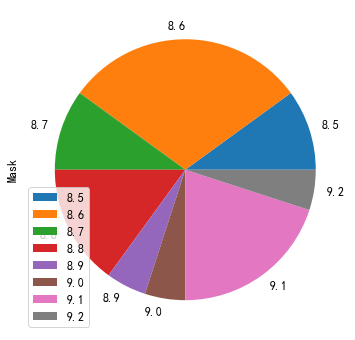

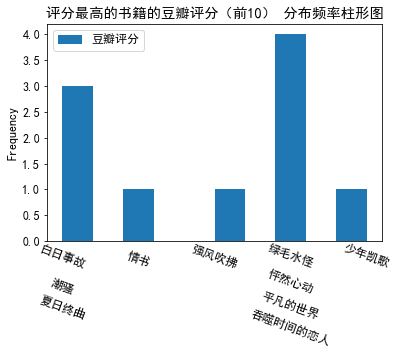

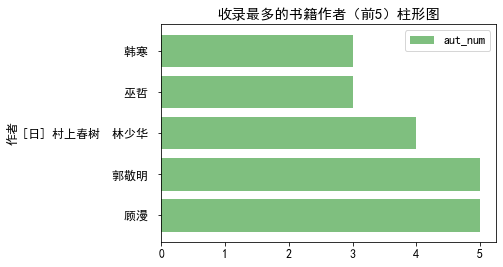

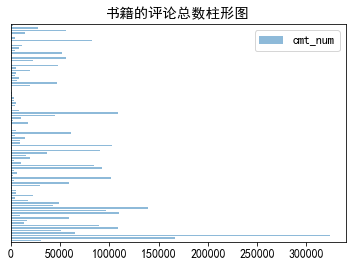

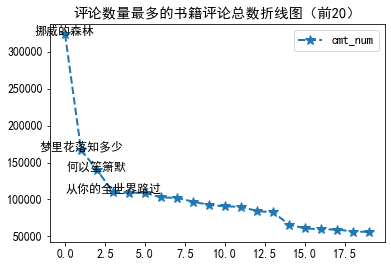

In [4]:
from pyecharts.charts import Tab
import os


def main():
    path = "MLAB.csv"    
    file = open(path, "w", encoding='utf-8')
    List = getList() 
    print("get list\n")
    listToCsv(List,file)
    print("store list\n")
    ranks_data = ranks(path)
    print("ranks\n")
    chigh_data = comment_high(path)
    print("chigh\n")
    auther_data = auther(path)
    print("auther\n")
    cnum_data = comment_num(path)
    print("cnum\n")
    cnum2_data = comment_num2(path)
    print("cnum2\n")
    publisher = newPublisher(path)
    print("publisher\n")
    writer = newWriter(path)
    print("writer\n")
    
    #二进制data集
    datas = [ranks_data,publisher,writer,auther_data,cnum_data,cnum2_data,chigh_data]
    
    root='''
    <html>
        <title>MLAB - data</title>
        <body>
            <div>
                <span style='white-space:pre;'>                                                   </span>
    '''
    
    #data转换为html
    index=1
    for data in datas:
        #encoded = data
        index=index+1
        
        if index==5:
            root = root + '''
            </div>
            <div>'''
        
        my_html = '''
           
               <img align = "middle" src="data:image/png;base64,{}" />
           
    '''.format(data.decode('utf-8'))
        imb = base64.b64encode(data)
        root = root + my_html
            
    root = root + '''
            </div>
        </body>
    </html>
    '''
    
    
    #rtree解析字符串为html代码
    html = etree.HTML(root)
    tree = etree.ElementTree(html)
    tree.write('MLAB.html')
    
    tab = Tab()
#    tab.add(Publisher,'Publisher')
#    tab.add(Writer,'Writer')
    #tab.render("MLAB.html")
    print("show html")
    os.system("MLAB.html")

if __name__=='__main__': 
	main()